In [1]:
import sys
sys.path.insert(1, '/home/ias627/tools')

In [2]:
from abg_python.snapshot_utils import openSnapshot, get_fnames
from abg_python.cosmo_utils import load_AHF
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def inrange(a, ra):
    a1, a2 = ra
    return (a1 <= a)&(a <= a2)

In [4]:
#h2_HR_sn1dy300ro100ss/snapdir_277

In [5]:
p0 = openSnapshot('/projects/b1026/isultan/sim/', 277, 0, loud=1)

/projects/b1026/isultan/sim/snapdir_277/snapshot_277.0.hdf5
This is a cosmological snapshot... converting to physical units
/projects/b1026/isultan/sim/snapdir_277/snapshot_277.1.hdf5
/projects/b1026/isultan/sim/snapdir_277/snapshot_277.2.hdf5
/projects/b1026/isultan/sim/snapdir_277/snapshot_277.3.hdf5


In [6]:
posC, Rvir = load_AHF('/projects/b1026/isultan/sim/', 277, 1, hubble=p0['HubbleParam'], extra_names_to_read=[])

In [7]:
# position relative to center
p0['CoordinatesRelative'] = p0['Coordinates'] - posC

In [8]:
# distance from halo center
p0['r'] = np.linalg.norm(p0['CoordinatesRelative'], axis=1)

In [9]:
# distance from halo center in units of virial radius
p0['r_scaled'] = p0['r']/Rvir

In [10]:
# volume of each particle
p0['Vi'] = p0['Masses']/p0['Density']

In [11]:
Tmask = p0['Temperature'] >= 1e5

In [12]:
rbins = np.logspace(np.log10(0.01), np.log10(1.1), 100)
# rbins = np.linspace(0, 1.1, 100)

rmid = (rbins[:-1]+rbins[1:])/2
Tbins = []

for r0,r1 in zip(rbins[:-1],rbins[1:]):
    idx = np.flatnonzero(Tmask & inrange( p0['r_scaled'], (r0, r1) ))
    Tavg = np.sum(p0['Temperature'][idx] * p0['Vi'][idx])/np.sum(p0['Vi'][idx])
    Tbins.append(Tavg)

Text(0.5, 1.0, '$z=1.0$')

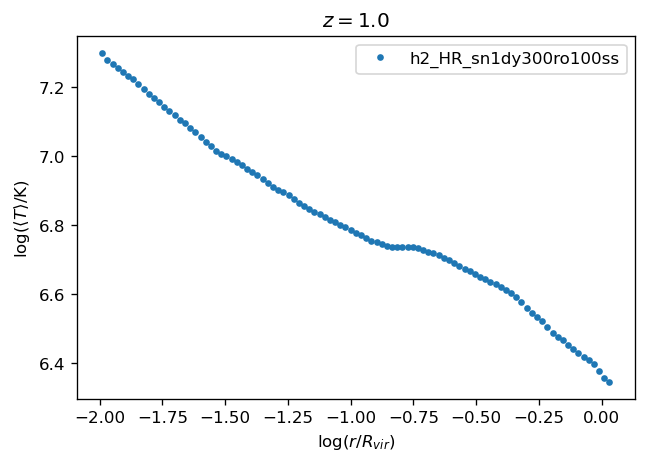

In [13]:
plt.figure(dpi=120)
plt.plot(np.log10(rmid), np.log10(Tbins), '.', label='h2_HR_sn1dy300ro100ss')
plt.xlabel(r'$\log (r/R_{vir})$')
plt.ylabel(r'$\log \left(\left<T\right>/\mathrm{K}\right)$')
plt.legend()
plt.title(f'$z={np.round(p0["Redshift"],2)}$')